# AnnVariables

This script runs repeated cross-validation as a search for suitable parameter values for 
the ANN and the genetic algorithm.

It has been re-run for all data-sets. The output of some are saved as text lower in the notebook.

In [1]:
# import stuffs
%matplotlib inline
import numpy as np
import pandas as pd
from pyplotthemes import get_savefig, classictheme as plt
plt.latex = True

## Load data

To load a different data, use the relevant *get*-method as shown by the commented line.

In [30]:
from datasets import get_nwtco, get_colon, get_lung, get_pbc, get_flchain

#d = get_colon(prints=True, norm_in=True, norm_out=False, training=True)
d = get_nwtco(prints=True, norm_in=True, norm_out=False, training=True)
d = d.astype(float)

durcol = d.columns[0]
eventcol = d.columns[1]

if np.any(d[durcol] < 0):
    raise ValueError("Negative times encountered")

print("End time:", d.iloc[:, 0].max())
#d

Input columns were normalized
Shape from (4028, 6) to (3021, 9)
Censored count: 2592.0 / 3021  = 85.80%
Final columns: ['edrel', 'rel', 'instit', 'histol', 'age', 'stage1', 'stage2', 'stage4', 'stage3']
End time: 6209.0


## Configure some helper methods and starting parameters

In [31]:
import ann
from classensemble import ClassEnsemble


def get_net(rows, incols, func=ann.geneticnetwork.FITNESS_SURV_KAPLAN_MIN, mingroup=None,
            popsize=100, generations=200, mutchance=0.15, mutstd=1.0, muthalf=0, conchance=0,
            crossover=ann.geneticnetwork.CROSSOVER_UNIFORM, crosschance=1.0,
            selection=ann.geneticnetwork.SELECTION_TOURNAMENT,
            architecture=None):
    outcount = 2
    
    if architecture is None:
        architecture = [0]
    
    hidden_count = np.sum(architecture)
    
    l = incols + hidden_count + outcount + 1
    net = ann.geneticnetwork(incols, hidden_count, outcount)
    net.fitness_function = func
    
    if mingroup is None:
        mingroup = int(0.25 * rows)
    
    # Be explicit here even though I changed the defaults
    net.connection_mutation_chance = conchance
    net.activation_mutation_chance = 0
    # Some other values
    net.crossover_method = crossover
    net.crossover_chance = crosschance
    net.selection_method = selection
    net.population_size = popsize
    net.generations = generations
    net.weight_mutation_chance = mutchance
    net.weight_mutation_factor = mutstd
    net.weight_mutation_halfpoint = muthalf


    ann.utils.connect_feedforward(net, architecture, hidden_act=net.TANH, out_act=net.SOFTMAX)
    #c = net.connections.reshape((l, l))
    #c[-outcount:, :(incols + hidden_count)] = 1
    #net.connections = c.ravel()
    
    return net

def _netgen(df, netcount, funcs=None, **kwargs):
    # Expects (function, mingroup)
    if funcs is None:
        funcs = [ann.geneticnetwork.FITNESS_SURV_KAPLAN_MIN,
                 ann.geneticnetwork.FITNESS_SURV_KAPLAN_MAX]
        
    rows = df.shape[0]
    incols = df.shape[1] - 2
    hnets = []
    lnets = []

    for i in range(netcount):
        if i % 2:
            n = get_net(rows, incols, funcs[0], **kwargs)
            hnets.append(n)
        else:
            n = get_net(rows, incols, funcs[1], **kwargs)
            lnets.append(n)
    
    return hnets, lnets

def _kanngen(df, netcount, **kwargs):
    return _netgen(df, netcount, **kwargs)

def _riskgen(df, netcount, **kwargs):
    return _netgen(df, netcount,
                   [ann.geneticnetwork.FITNESS_SURV_RISKGROUP_HIGH,
                    ann.geneticnetwork.FITNESS_SURV_RISKGROUP_LOW],
                   **kwargs)

def get_kanngen(netcount, **kwargs):
    return lambda df: _kanngen(df, netcount, **kwargs)
#e = ClassEnsemble(netgen=netgen)
#er = ClassEnsemble(netgen=riskgen)

class NetFitter(object):
    def __init__(self, func=ann.geneticnetwork.FITNESS_SURV_KAPLAN_MIN, **kwargs):
        self.kwargs = kwargs
        self.func = func
        
    def fit(self, df, duration_col, event_col):
        '''
        Same as learn, but instead conforms to the interface defined by
        Lifelines and accepts a data frame as the data. Also generates
        new networks using self.netgen is it was defined.
        '''
        #print("dataframe shit", df is None, df.shape)
        dsafe = df.copy()
        rows = df.shape[0]
        incols = df.shape[1] - 2
        #print("Getting net...")
        self.net = get_net(rows, incols, self.func, **self.kwargs)
        # Save columns for prediction later
        self.x_cols = df.columns - [duration_col, event_col]
        #print("Learning on:", df.shape)
        #print("Conn chance:", self.net.connection_mutation_chance)
        #print("Connsbefore", self.net.connections.reshape((15, 15)))
        self.net.learn(np.array(df[self.x_cols]),
                       np.array(df[[duration_col, event_col]]))
        #print("Conns after", self.net.connections)
        #print("Weights after", self.net.weights)
        #print("After learning:", df.shape)
        
    def get_log(self, df):
        '''
        Returns a truncated training log
        '''
        return pd.Series(self.net.log[:, 0])
    
    def predict_classes(self, df):
        '''
        Predict the classes of an entire DateFrame.

        Returns a DataFrame.
        '''
        labels = []

        for idx, tin in enumerate(df[self.x_cols].values):
            res = self.net.predict_class(tin)
            if res == 0 and self.func == ann.geneticnetwork.FITNESS_SURV_KAPLAN_MIN:
                labels.append('high')
            elif res == 0:
                labels.append('low')
            else:
                labels.append('mid')
        retval = pd.DataFrame(index=df.index, columns=['group'])
        retval.iloc[:, 0] = labels
        return retval
    
net = get_net(2, 2)

In [32]:
from stats import k_fold_cross_validation
from lifelines.estimation import KaplanMeierFitter, median_survival_times


def score(T_actual, labels, E_actual):
    '''
    Return a score based on grouping
    '''
    scores = []
    labels = labels.ravel()
    for g in ['high', 'mid', 'low']:
        members = labels == g
        
        if np.sum(members) > 0:
            kmf = KaplanMeierFitter()
            kmf.fit(T_actual[members],
                    E_actual[members],
                    label='{}'.format(g))
            
            # Last survival time
            if np.sum(E_actual[members]) > 0:
                lasttime = np.max(T_actual[members][E_actual[members] == 1])
            else:
                lasttime = np.nan
        
            # End survival rate, median survival time, member count, last event
            subscore = (kmf.survival_function_.iloc[-1, 0],
                        median_survival_times(kmf.survival_function_),
                        np.sum(members),
                        lasttime)
        else:
            # Rpart might fail in this respect
            subscore = (np.nan, np.nan, np.sum(members), np.nan)
            
        scores.append(subscore)
    return scores

# Use to get training data score
def logscore(T_actual, log, E_actual):
    # Return last value in the log
    return log[-1]

# Use for validation
def high_median_time(T_actual, labels, E_actual):
    members = (labels == 'high').ravel()
    if np.sum(members) > 0:
        kmf = KaplanMeierFitter()
        kmf.fit(T_actual[members],
                E_actual[members])
        return median_survival_times(kmf.survival_function_)
    else:
        return np.nan
    

## Compare stuff

Here some default parameters are set, together with the range of possible values.

Note that this cell can be re-executed without overwriting the current results 
(useful to load a different data-set or changing the range of possible values).

In [33]:
default_values = dict(crossover = 2, # (twopoint)
   mutchance = 0.3,
   generations = 300,
   crosschance = 0.75,
   selection = 0, # (geometric)
   muthalf = 0,
   conchance = 0.0,
   popsize = 100,
   architecture = [4],
   mutstd = 1.0)
possible_values = dict(
                       popsize=[25, 50, 100, 200, 300],
                       #generations=[1, 10, 50, 100, 500],
                       #conchance=[0, 0.01, 0.05, 0.1, 0.25, 0.5, 1.0],
                       mutchance=[0.15, 0.30, 0.6, 0.9],
                       mutstd=[0.5, 1.0, 2.0, 3.0],
                       crosschance=[0.25, 0.5, 0.75, 1.0],
                       crossover=[ann.geneticnetwork.CROSSOVER_UNIFORM,
                                  ann.geneticnetwork.CROSSOVER_ONEPOINT,
                                  ann.geneticnetwork.CROSSOVER_TWOPOINT],
                       selection=[ann.geneticnetwork.SELECTION_TOURNAMENT,
                                  ann.geneticnetwork.SELECTION_GEOMETRIC,
                                  ann.geneticnetwork.SELECTION_ROULETTE],
                       architecture=[[0],
                                    [4],
                                    [4, 4]])

# Update values as we go along
try:
    current_values
except NameError:
    current_values = default_values.copy()

print(current_values)

{'crossover': 2, 'mutchance': 0.15, 'generations': 300, 'crosschance': 0.75, 'selection': 2, 'muthalf': 0, 'conchance': 0.0, 'popsize': 200, 'architecture': [4], 'mutstd': 2.0}


## Define what the best is

The best parameter is the one that results in a longer median survival time (networks are configured to find low-risk groups).

In [34]:
def get_winning_value(values, repeat_results, current_val):
    winner = 0, 0
    for i, x in enumerate(values):
        mres = np.median(np.array(repeat_results)[:, i, :])
        # For stability
        if mres > winner[0] or (x == current_val and mres >= winner[0]):
            winner = mres, x
    return winner[1]

## Check all combinations of values

Not really all combinations. But allow one variable to be changed at a time. Then re-run to see if this affects what the best value is for the rest. Stop at some maximum repcount or in case no variable change was better than what has been found.

In [35]:
print("Starting values")
for k, v in current_values.items():
    print("  ", k, "=", v)

# Repeat all variables
n = 10
k = 2
repcount = 0
stable = False
while repcount < 4 and not stable:
    repcount += 1
    print(repcount)
    stable = True
    for key, values in sorted(possible_values.items()):
        print(key)
        models = []
        for x in values:
            kwargs = current_values.copy()
            kwargs[key] = x
            model = NetFitter(func=ann.geneticnetwork.FITNESS_SURV_KAPLAN_MIN, 
                          **kwargs)
            model.var_label = key
            model.var_value = x
            models.append(model)
        # Train and test
        repeat_results = []
        for rep in range(n):
            result = k_fold_cross_validation(models, d, durcol, eventcol, 
                                             k=k, 
                                             evaluation_measure=logscore, 
                                             predictor='get_log')
            repeat_results.append(result)
        # See who won
        winval = get_winning_value(values, repeat_results, current_values[key])
        if winval != current_values[key]:
            stable = False
            print(key, current_values[key], "->", winval)
            current_values[key] = winval

print("\nValues optimized after", repcount, "iterations")
for k, v in current_values.items():
    print("  ", k, "=", v)

Starting values
   crossover = 2
   mutchance = 0.15
   generations = 300
   crosschance = 0.75
   selection = 2
   muthalf = 0
   conchance = 0.0
   popsize = 200
   architecture = [4]
   mutstd = 2.0
1
architecture
architecture [4] -> [4, 4]
crosschance
crosschance 0.75 -> 0.5
crossover
crossover 2 -> 1
mutchance
mutstd
mutstd 2.0 -> 3.0
popsize
popsize 200 -> 300
selection
selection 2 -> 1
2
architecture
crosschance
crossover
mutchance
mutstd
popsize
selection
selection 1 -> 2
3
architecture
crosschance
crosschance 0.5 -> 0.25
crossover
crossover 1 -> 2
mutchance
mutstd
mutstd 3.0 -> 1.0
popsize
popsize 300 -> 200
selection
4
architecture
crosschance
crosschance 0.25 -> 0.5
crossover
crossover 2 -> 1
mutchance
mutchance 0.15 -> 0.9
mutstd
mutstd 1.0 -> 2.0
popsize
popsize 200 -> 300
selection

Values optimized after 4 iterations
   crossover = 1
   mutchance = 0.9
   generations = 300
   crosschance = 0.5
   selection = 2
   muthalf = 0
   conchance = 0.0
   popsize = 300
   archite

In [36]:
# Just print results from above
print("\nValues optimized after", repcount, "iterations")
for k, v in current_values.items():
    if k == 'selection':
        if v == ann.geneticnetwork.SELECTION_GEOMETRIC:
            name = 'geometric'
        elif v == ann.geneticnetwork.SELECTION_ROULETTE:
            name = 'roulette'
        else:
            name = 'tournament'
    elif k == 'crossover':
        if v == ann.geneticnetwork.CROSSOVER_ONEPOINT:
            name = 'onepoint'
        elif v == ann.geneticnetwork.CROSSOVER_TWOPOINT:
            name = 'twopoint'
        else:
            name = 'uniform'
    else:
        name = None
        
    if name is None:
        print("  ", k, "=", v)
    else:
        print("  ", k, "=", v, "({})".format(name))


Values optimized after 4 iterations
   crossover = 1 (onepoint)
   mutchance = 0.9
   generations = 300
   crosschance = 0.5
   selection = 2 (tournament)
   muthalf = 0
   conchance = 0.0
   popsize = 300
   architecture = [4, 4]
   mutstd = 2.0


## Results from above on multiple data sets

As can be seen above, some values tends to fluctuate constantly (example mutstd). This is interpreted
as no one value having a clear advantage over another. This is taken into account with the values seen below
to determine the final parameters, which are set in `helpers.py` (*get_net* method):

    # Number of neurons in hidden layer, and output layer
    hidden_count = 4
    outcount = 2

    # Can only mutate weights, not connections or activation functions
    net.connection_mutation_chance = 0.0
    net.activation_mutation_chance = 0
    
    # Training parameters used for all experiments
    net.crossover_method = net.CROSSOVER_TWOPOINT
    net.selection_method = net.SELECTION_TOURNAMENT
    net.population_size = 200
    net.generations = 1000
    net.weight_mutation_chance = 0.5
    net.weight_mutation_factor = 1.5
    net.crossover_chance = 0.75

Generations is simply set to be well beyond the convergence point. Other values are set by
majority vote (crossover method, selection method), or by rough averaging (population size, mutation factors, crossover chance).

### lung (training)
Values optimized after 10 iterations
-   crossover = 2 (twopoint)
-   mutchance = 0.3
-   generations = 300
-   crosschance = 0.75
-   selection = 0 (geometric)
-   muthalf = 0
-   conchance = 0.0
-   popsize = 100
-   architecture = [4]
-   mutstd = 1.0

### colon (training)
Values optimized after 4 iterations
-   crossover = 2 (twopoint)
-   mutchance = 0.15
-   generations = 300
-   crosschance = 0.75
-   selection = 2 (tournament)
-   muthalf = 0
-   conchance = 0.0
-   popsize = 200
-   architecture = [4]
-   mutstd = 2.0

### nwtco (training)
Values optimized after 4 iterations
-   crossover = 1 (onepoint)
-   mutchance = 0.9
-   generations = 300
-   crosschance = 0.5
-   selection = 2 (tournament)
-   muthalf = 0
-   conchance = 0.0
-   popsize = 300
-   architecture = [4, 4]
-   mutstd = 2.0

## Train a network with the parameters on high-risk group

This is just to check what the result is. It has no bearing on the choice of parameters above

In [26]:
#netcount = 6
models = []
# Try different epoch counts
for x in range(1):
    #e = ClassEnsemble(netgen=get_kanngen(netcount, generations=x))
    e = NetFitter(func=ann.geneticnetwork.FITNESS_SURV_KAPLAN_MIN, 
                  **current_values)
    #, mingroup=int(0.25*d.shape[0]))
    e.var_label = 'Current values'
    e.var_value = '1 net'
    models.append(e)


In [27]:
n = 10
k = 3
# Repeated cross-validation
repeat_results = []
for rep in range(n):
    print("n =", rep)
    # Training
    #result = k_fold_cross_validation(models, d, durcol, eventcol, k=k, evaluation_measure=logscore, predictor='get_log')
    # Validation
    result = k_fold_cross_validation(models, d, durcol, eventcol, k=k,
                                     evaluation_measure=high_median_time,
                                     predictor='predict_classes')
    repeat_results.append(result)
#repeat_results

n = 0
n = 1
n = 2
n = 3
n = 4
n = 5
n = 6
n = 7
n = 8
n = 9


### Plot group

Lower is better.

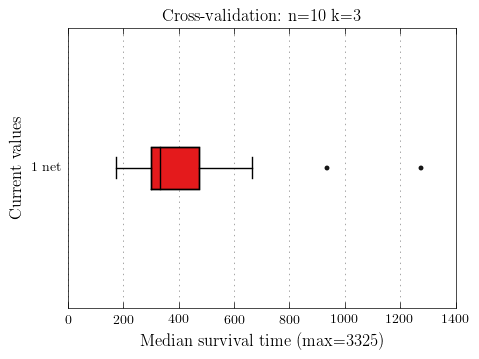

In [28]:
def plot_score(repeat_results, models):
    boxes = []
    labels = []
    var_label = None
    # Makes no sense for low here for many datasets...
    for i, m in enumerate(models):
        labels.append(str(m.var_value))
        var_label = m.var_label
        vals = []
        for result in repeat_results:
            vals.extend(result[i])
        boxes.append(vals)

    plt.figure()
    plt.boxplot(boxes, labels=labels, vert=False, colors=plt.colors[:len(models)])
    plt.ylabel(var_label)
    plt.title("Cross-validation: n={} k={}".format(n, k))
    plt.xlabel("Median survival time (max={:.0f})".format(d[durcol].max()))
    #plt.gca().set_xscale('log')
        
plot_score(repeat_results, models)